### Installation Process:
- Download model weights and put them in the project root folder: https://drive.google.com/file/d/1uUeXjEUoD2XF_6YjD_fsct-TJp7TFiqh
- python -m venv .venv
- source .venv/bin/activate && pip install -r requirements.txt
- Use created environment with all necessary dependencies installed to run this notebook. Happy hacking!
Gio

In [2]:
from PIL import Image
import sys
import torch
from torchvision import transforms
from IPython.display import display

from models.birefnet import BiRefNet
from utils import check_state_dict

birefnet = BiRefNet(bb_pretrained=False)
state_dict = torch.load('BiRefNet-portrait-epoch_150.pth', map_location='cpu', weights_only=True)
state_dict = check_state_dict(state_dict)
birefnet.load_state_dict(state_dict)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.set_float32_matmul_precision(['high', 'highest'][0])

birefnet.to(device)
birefnet.eval()
print('BiRefNet is ready to use.')

transform_image = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


/Users/gio/code/background_removal/.venv/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


BiRefNet is ready to use.


### Change this path to the video you want to process.

In [4]:
VIDEO_SRC_PATH = "video/IMG_1079.MOV"

In [6]:
import os
import cv2


src_dir = os.path.join('frames-video_{}'.format(os.path.splitext(os.path.basename(VIDEO_SRC_PATH))[0]))
video_ext = os.path.splitext(VIDEO_SRC_PATH)[-1]
video_dst_path_mask = VIDEO_SRC_PATH.replace(video_ext, '-preds_mask'+video_ext)
video_dst_path_subject = VIDEO_SRC_PATH.replace(video_ext, '-preds_subject'+video_ext)
vidcap = cv2.VideoCapture(VIDEO_SRC_PATH)
fps = vidcap.get(cv2.CAP_PROP_FPS)
success, image = vidcap.read()

video_writer_shape = image.shape[:2][::-1]
video_writer_mask = cv2.VideoWriter(video_dst_path_mask, cv2.VideoWriter_fourcc(*'mp4v'), fps, video_writer_shape, isColor=False)
video_writer_subject = cv2.VideoWriter(video_dst_path_subject, cv2.VideoWriter_fourcc(*'mp4v'), fps, video_writer_shape, isColor=True)

count = 0
while success:
    os.makedirs(src_dir, exist_ok=True)
    cv2.imwrite(os.path.join(src_dir, 'frame_{}.png'.format(count)), image)
    success, image = vidcap.read()
    count += 1

f"{count} frames extracted"

'173 frames extracted'

### Make mask predictions and save them for further debugging.

Processing frames-video_IMG_1079/frame_6.png ...
Processing frames-video_IMG_1079/frame_12.png ...
Processing frames-video_IMG_1079/frame_13.png ...
Processing frames-video_IMG_1079/frame_7.png ...
Processing frames-video_IMG_1079/frame_5.png ...
Processing frames-video_IMG_1079/frame_11.png ...
Processing frames-video_IMG_1079/frame_10.png ...
Processing frames-video_IMG_1079/frame_4.png ...
Processing frames-video_IMG_1079/frame_0.png ...
Processing frames-video_IMG_1079/frame_14.png ...
Processing frames-video_IMG_1079/frame_15.png ...
Processing frames-video_IMG_1079/frame_1.png ...
Processing frames-video_IMG_1079/frame_3.png ...
Processing frames-video_IMG_1079/frame_17.png ...
Processing frames-video_IMG_1079/frame_16.png ...
Processing frames-video_IMG_1079/frame_2.png ...
Processing frames-video_IMG_1079/frame_26.png ...
Processing frames-video_IMG_1079/frame_18.png ...
Processing frames-video_IMG_1079/frame_24.png ...
Processing frames-video_IMG_1079/frame_25.png ...
Processi

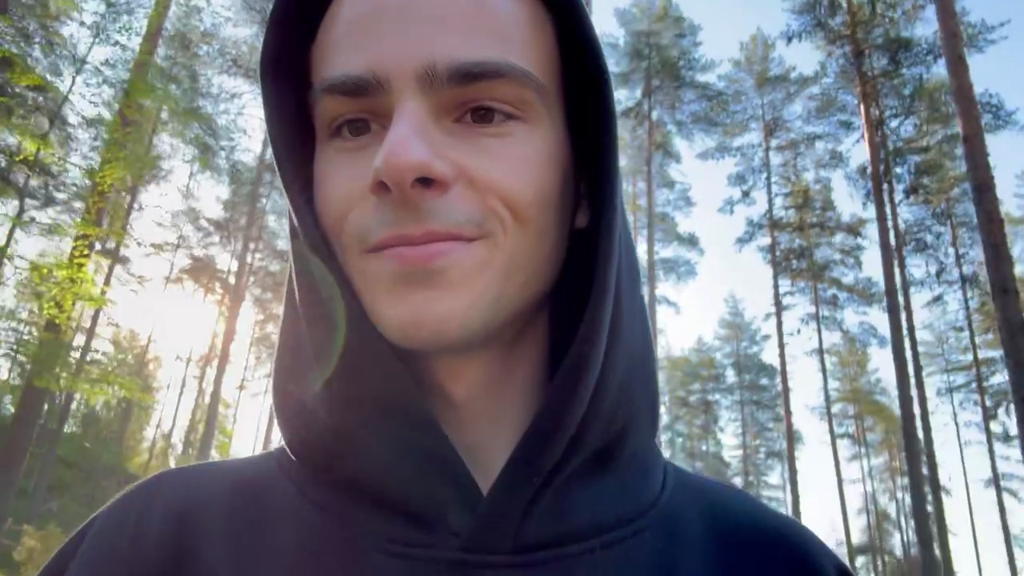

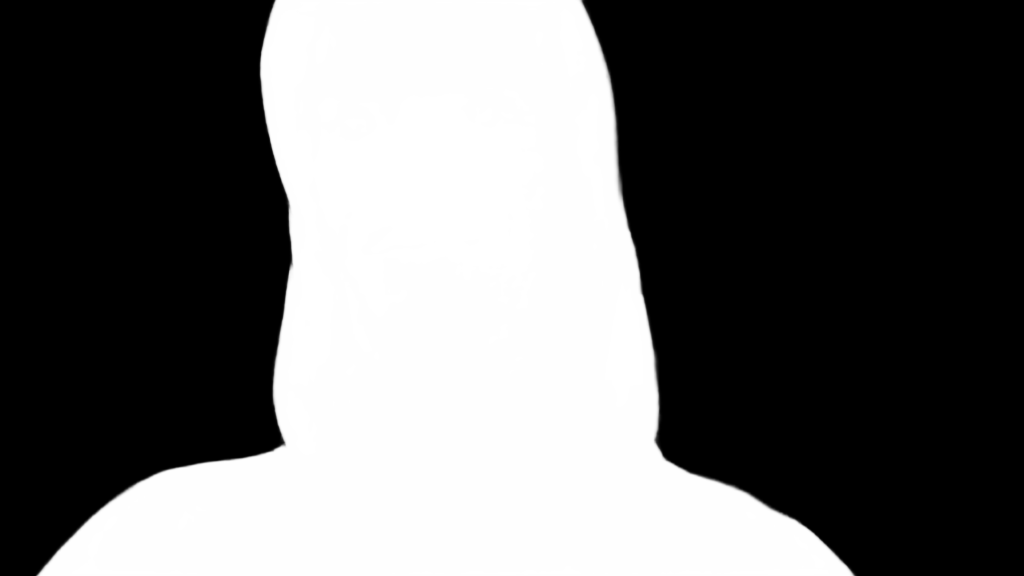

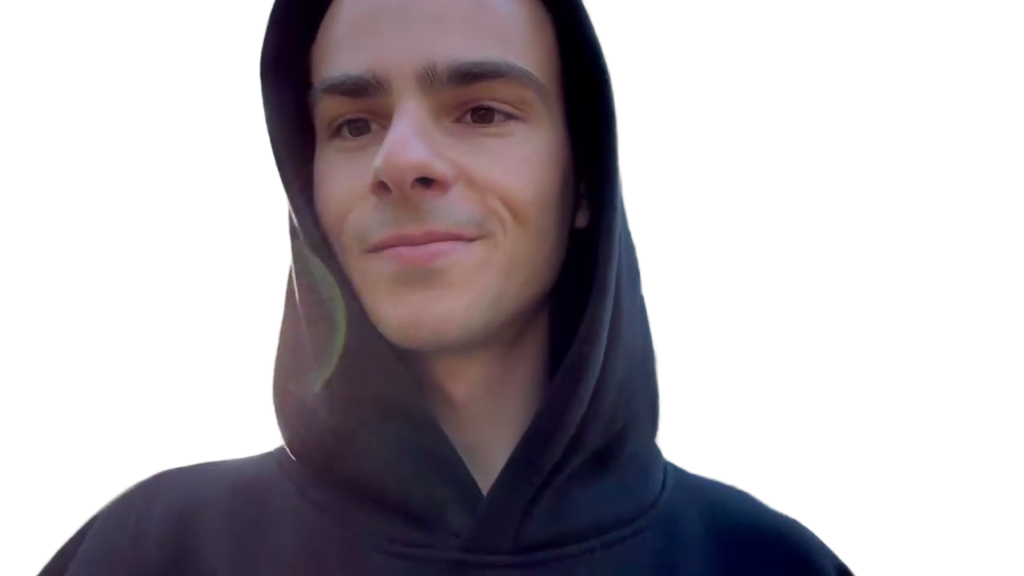

In [7]:
import os
from glob import glob
from image_proc import refine_foreground

image_paths = glob(os.path.join(src_dir, '*'))
dst_dir = "predictions"
os.makedirs(dst_dir, exist_ok=True)
for image_path in image_paths:
    print('Processing {} ...'.format(image_path))
    image = Image.open(image_path)
    input_images = transform_image(image).unsqueeze(0).to(device)

    with torch.no_grad():
        preds = birefnet(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()

    pred_pil = transforms.ToPILImage()(pred)
    pred_pil.resize(image.size).save(image_path.replace(src_dir, dst_dir))

    image_masked = refine_foreground(image, pred_pil)
    image_masked.putalpha(pred_pil.resize(image.size))


scale_ratio = 1024 / max(image.size)
scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))

display(image.resize(scaled_size))
display(pred_pil.resize(scaled_size))
display(image_masked.resize(scaled_size))

In [9]:
import numpy as np
from moviepy import ImageSequenceClip


def get_processed_image(image_path: str, mask_path: str) -> np.array:
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)
    mask_normalized = mask / 255.0
    background = blurred_image * (1 - mask_normalized[:, :, np.newaxis])
    foreground = image * mask_normalized[:, :, np.newaxis]

    final_image = background + foreground
    final_image = np.clip(final_image, 0, 255).astype(np.uint8)

    return cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)


def extract_number(filename):
    return int(filename.split("_")[-1].split(".")[0])


image_paths = sorted(image_paths, key=extract_number)
mask_paths = sorted(glob(os.path.join(dst_dir, '*.png')), key=extract_number)

if len(image_paths) != len(mask_paths):
    raise ValueError("The amount of masks should be equal the amount of images.")

frames = []
for image_path, mask_path in zip(image_paths, mask_paths):
    final_image = get_processed_image(image_path, mask_path)
    frames.append(final_image)

video_output_path = "output_video.mp4"
clip = ImageSequenceClip(frames, fps=fps)
clip.write_videofile(video_output_path, codec='libx264')

print(f"The video is saved as: {video_output_path}")

MoviePy - Building video output_video.mp4.
MoviePy - Writing video output_video.mp4



MoviePy - Done !
MoviePy - video ready output_video.mp4
The video is saved as: output_video.mp4
